# Calculations with Random Data

In [ ]:
import sys
sys.path.append("../..")

In [ ]:
import os
import time
import scanpy as sc
import idtrack
import pickle
import tqdm
import random

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
local_dir = "/lustre/groups/ml01/workspace/kemal.inecik/idtrack_temp"
idt = idtrack.API(local_repository=local_dir)
idt.configure_logger()
idt.initialize_graph(organism_name='homo_sapiens', ensembl_release=107, return_test=True)
idt.calculate_graph_caches() 

In [ ]:
def get_matching(convert_output):    
    d = idt.classify_multiple_conversion([convert_output])
    return {i: len(d[i]) for i in ["matching_1_to_0", "matching_1_to_1", "matching_1_to_n"]}

In [ ]:
subset_external = ["assembly_38_ensembl_gene", 'assembly_38_ensembl_transcript', 
                   "Vega gene", "RFAM", "HGNC Symbol", "NCBI gene", 
                   "Havana gene", "CCDS", "Uniprot/SWISSPROT", "RefSeq_mRNA"]

In [ ]:
for iteration in [101, 102]:

    identifier_dict = dict()
    for n in idt.track.graph.nodes:    
        for j in  {i[0] for i in idt.track.graph.node_trios[n]}:
            if j in identifier_dict:
                identifier_dict[j].append(n)
            else:
                identifier_dict[j] = [n]
    for ind, j in enumerate(identifier_dict):
        random.seed(ind + iteration)
        try:
            identifier_dict[j] = random.sample(sorted(set(identifier_dict[j])), 1000)
        except ValueError:
            # print(j, end=", ")
            identifier_dict[j] = random.sample(sorted(set(identifier_dict[j])), len(identifier_dict[j]))

    # Example IDs
    # for j in identifier_dict:
    #     print(j, end=": ")
    #     print(identifier_dict[j][:10], end="\n\n")

    identifier_duos = dict()
    for ind1, i in enumerate(subset_external):
        if i not in identifier_duos:
            identifier_duos[i] = list()
        for ind2, j in enumerate(identifier_dict[i]):
            random.seed(ind1 + ind2 + iteration)
            trio = random.choice(list(idt.track.graph.node_trios[j]))
            if trio[2] <= 107:
                identifier_duos[i].append((j, trio[2]))

    all_results = dict()
    for fer in [False, True]:
        print(f"With From Release: {fer}")
        r = dict()
        for ter in [107, 98, 89, 80]:
            print(f"To Ensembl Release: {ter}")
            results = dict()
            for i in identifier_duos:
                print(f"{i}", end=", ")
                if i not in results:
                    results[i] = {'matching_1_to_0': 0, 'matching_1_to_1': 0, 'matching_1_to_n': 0}

                t0 = time.time()
                for j in identifier_duos[i]:
                    c = idt.convert_identifier(j[0], from_release=j[1] if fer else None, to_release=ter, final_database="ensembl_gene")
                    gm = get_matching(c)
                    for k in gm:
                        results[i][k] += gm[k]
                t1 = time.time()
                results[i].update({"time": t1-t0, "count": len(identifier_duos[i])})
            r[ter] = results
            print()
        all_results["with_from_release" if fer else "no_from_release"] = r

    time_suffix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
    local_dir = "/lustre/groups/ml01/workspace/kemal.inecik/idtrack_temp"
    file_path = os.path.join(local_dir, f"results_for_random_external_conversions_{iteration}_{time_suffix}.pk")
    with open(file_path, 'wb') as handle:
        pickle.dump(all_results, handle)
        print(f"Saved: {file_path}")
    print()

In [ ]:
# choose an external database, and ensembl gene id
# choose random 10000 IDs from random ens releases
# convert to ensembl gene id 107
# get 1-to-1, 1-to-0, 1-to-n matchings, barplot...

In [ ]:
# choose hgnc, ncbi, uniprot, ensembl gene
# make from ensembl release 80 to 105, incrementing 3 or 5
# get 1-to-1, 1-to-0, 1-to-n matchings, barplot...

Print plot

In [1]:
import sys
sys.path.append("../..")

In [2]:
import os
import time
import pickle
import copy
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [5]:
local_dir = "/lustre/groups/ml01/workspace/kemal.inecik/idtrack_temp"

In [6]:
!ls -lh /lustre/groups/ml01/workspace/kemal.inecik/idtrack_temp

total 15G
-rw-r--r--. 1 kemal.inecik OG-ICB-User  18K Feb  2 10:38 figure_across_datasets.pdf
-rw-r--r--. 1 kemal.inecik OG-ICB-User  16K Feb  2 10:33 figure_across_releases.pdf
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User 622M Oct 17 17:18 graph_homo_sapiens_ens107_min79_narrow.pickle
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User 7.2G Oct 17 15:01 homo_sapiens_assembly-37.h5
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User 7.0G Oct 31 09:44 homo_sapiens_assembly-38.h5
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User  45K Aug 12 15:57 homo_sapiens_externals_modified.yml
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User 2.2M Nov 10 10:48 results_for_hlca_core_only_ensembl_gene_20221110-094821.pk
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User 2.4M Nov 10 10:43 results_for_hlca_core_only_HGNC Symbol_20221110-094335.pk
-rw-rwxr--+ 1 kemal.inecik OG-ICB-User  57M Nov  1 20:13 results_for_hlca_datasets_ensembl_gene_20221101-191345.pk
-rw-r--r--. 1 kemal.inecik OG-ICB-User  57M Jan 30 03:31 results_for_hlca_datasets_ensembl_gene_20230130-02314

In [7]:
with open(local_dir + "/results_for_random_external_conversions_1_20230129-233747.pk", 'rb') as pickle_file_1:
    res1 = pickle.load(pickle_file_1)
with open(local_dir + "/results_for_random_external_conversions_2_20230130-031239.pk", 'rb') as pickle_file_2:
    res2 = pickle.load(pickle_file_2)
with open(local_dir + "/results_for_random_external_conversions_1001_20230130-194819.pk", 'rb') as pickle_file_3:
    res3 = pickle.load(pickle_file_3)
with open(local_dir + "/results_for_random_external_conversions_1002_20230130-195844.pk", 'rb') as pickle_file_4:
    res4 = pickle.load(pickle_file_4)
with open(local_dir + "/results_for_random_external_conversions_1011_20230130-202727.pk", 'rb') as pickle_file_5:
    res5 = pickle.load(pickle_file_5)
with open(local_dir + "/results_for_random_external_conversions_1012_20230130-204143.pk", 'rb') as pickle_file_6:
    res6 = pickle.load(pickle_file_6)
with open(local_dir + "/results_for_random_external_conversions_1031_20230130-213318.pk", 'rb') as pickle_file_7:
    res7 = pickle.load(pickle_file_7)
    
res = [res1, res2, res3, res4, res5, res6, res7]

In [8]:
df_list = list()
for r, rv in enumerate(res):
    for i, iv in rv.items():
        for j, jv in iv.items():
            for k, kv in jv.items():
                count = kv["count"]
                for l, lv in kv.items():
                    if l.startswith("matching_1"):
                        df_list.append([r+1, i, j, k, l, lv/count])
df = pd.DataFrame(df_list, columns=["replicate", "from_release", "to_release", "database", "metric", "score"])
df["database"] = df["database"].replace({'assembly_38_ensembl_gene': "Ensembl gene",
                                        'assembly_38_ensembl_transcript': "Ensembl mRNA",
                                        "Uniprot/SWISSPROT": "UniProt",
                                        "RefSeq_mRNA": "RefSeq mRNA"})

In [9]:
k__ = list()
for ind, j in df.iterrows():
    
    s = copy.deepcopy(j['score'])
    if ind % 3 == 0:
        total = s
    else:
        total += s
        j['score'] = total
    k__.append(j)
df_cum = pd.DataFrame(k__)
df_cum

,replicate,from_release,to_release,database,metric,score
0,1,no_from_release,107,Ensembl gene,matching_1_to_0,0.040
1,1,no_from_release,107,Ensembl gene,matching_1_to_1,0.999
2,1,no_from_release,107,Ensembl gene,matching_1_to_n,1.000
3,1,no_from_release,107,Ensembl mRNA,matching_1_to_0,0.005
4,1,no_from_release,107,Ensembl mRNA,matching_1_to_1,0.985
...,...,...,...,...,...,...
1675,7,with_from_release,80,UniProt,matching_1_to_1,0.996
1676,7,with_from_release,80,UniProt,matching_1_to_n,1.000
1677,7,with_from_release,80,RefSeq mRNA,matching_1_to_0,0.001
1678,7,with_from_release,80,RefSeq mRNA,matching_1_to_1,0.993


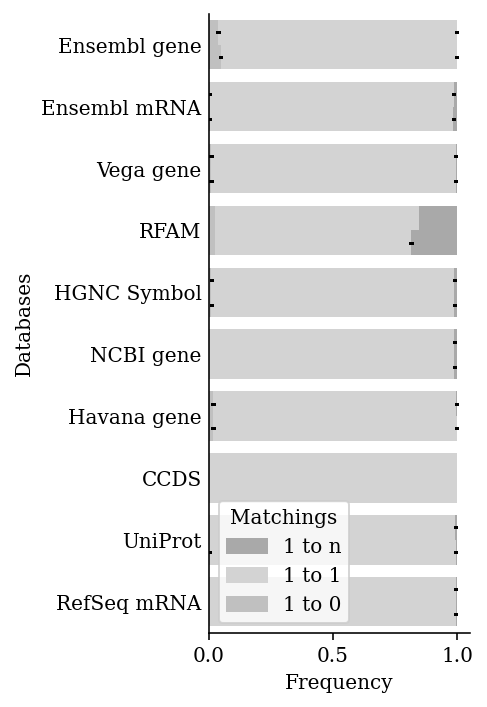

In [10]:
plt.figure(figsize=(3.5,5))
sns.barplot(data=df_cum[(df_cum["metric"]=="matching_1_to_n") & (df_cum["to_release"]==107)], 
            y="database", 
            hue="from_release", errwidth=1.5,
            x="score", 
            palette=['darkgray', 'darkgray'], errcolor='black'
           )
sns.barplot(data=df_cum[(df_cum["metric"]=="matching_1_to_1") & (df_cum["to_release"]==107)], 
            y="database", 
            hue="from_release", errwidth=1.5,
            x="score", 
            palette=['lightgray', 'lightgray'], errcolor='black'
           )
m = sns.barplot(data=df_cum[(df_cum["metric"]=="matching_1_to_0") & (df_cum["to_release"]==107)], 
            y="database", 
            hue="from_release", errwidth=1.5,
            x="score", 
            palette=['silver', 'silver'], errcolor='black'
           )



darkgray_patch = mpatches.Patch(color='darkgray', label='1 to n')
lightgray_patch = mpatches.Patch(color='lightgray', label='1 to 1')
silver_patch = mpatches.Patch(color='silver', label='1 to 0')
plt.legend(handles=[darkgray_patch, lightgray_patch, silver_patch], loc='lower left', title="Matchings")

sns.despine()
plt.tight_layout()
plt.xlabel("Frequency")
plt.ylabel("Databases")
#plt.gca().legend().set_visible(False)
plt.gca().tick_params(axis='y', which='both',length=0)
plt.savefig(local_dir + "/figure_across_datasets.pdf")




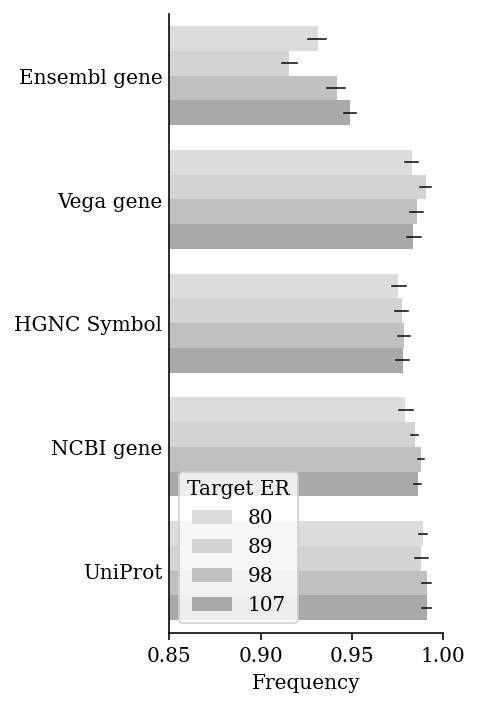

In [14]:
plt.figure(figsize=(3.5,5))
df2=df[df["database"].isin(["Ensembl gene", "HGNC Symbol", "UniProt", "Vega gene", "NCBI gene"])]
sns.barplot(data=df2[(df2["metric"]=="matching_1_to_1") & (df2["from_release"]=="with_from_release")], 
            y="database", 
            hue="to_release", errwidth=0.75,
            x="score",
            palette=['gainsboro', 'lightgray', 'silver', 'darkgray'], errcolor='black'
           )

sns.despine()
plt.tight_layout()
plt.xlabel("Frequency")
plt.ylabel("")
plt.xlim((0.85, 1.0))
plt.gca().legend(loc='lower left', title="Target ER")
plt.gca().tick_params(axis='y', which='both',length=0)
plt.savefig(local_dir + "/figure_across_releases.pdf")



In [ ]:
# time and boxplot for 